### Optimal control of the ALN model
This notebook shows how to compute the optimal control (OC) signal for the ALN model for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2


# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
model = ALNModel()
model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration

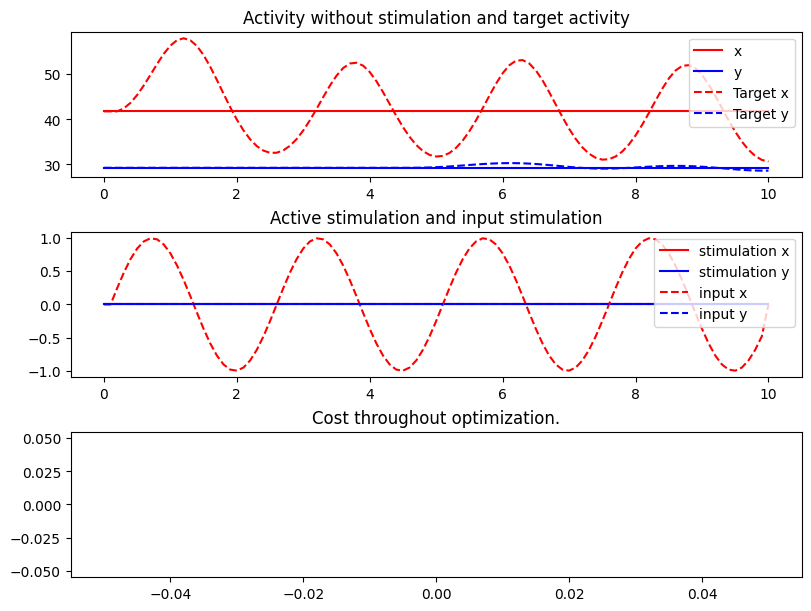

In [3]:
# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.run()

# Define the result of the stimulation as target
target = getstate(model)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 321.0336715448232
Cost in iteration 25: 0.45668223931610213
Cost in iteration 50: 0.04673065343134406
Cost in iteration 75: 0.014036967934316566
Cost in iteration 100: 0.006103042785878335
Cost in iteration 125: 0.003350403799601075
Cost in iteration 150: 0.0021009555075218855
Cost in iteration 175: 0.0014380107732207238
Cost in iteration 200: 0.001022140439191385
Cost in iteration 225: 0.0007699498237050896
Cost in iteration 250: 0.0005847738518044136
Cost in iteration 275: 0.0004590721894660564
Cost in iteration 300: 0.00036747886226740116
Cost in iteration 325: 0.00029813110462738204
Cost in iteration 350: 0.00024520554005332765
Cost in iteration 375: 0.00020353540802115142
Cost in iteration 400: 0.0001705951439963652
Cost in iteration 425: 0.00014400427366125575
Cost in iteration 450: 0.00012238365768150517
Cost in iteration 475: 0.00010513343276690961
Cost in iteration 500: 8.988196235839942e-05
Final cost : 8.9881962

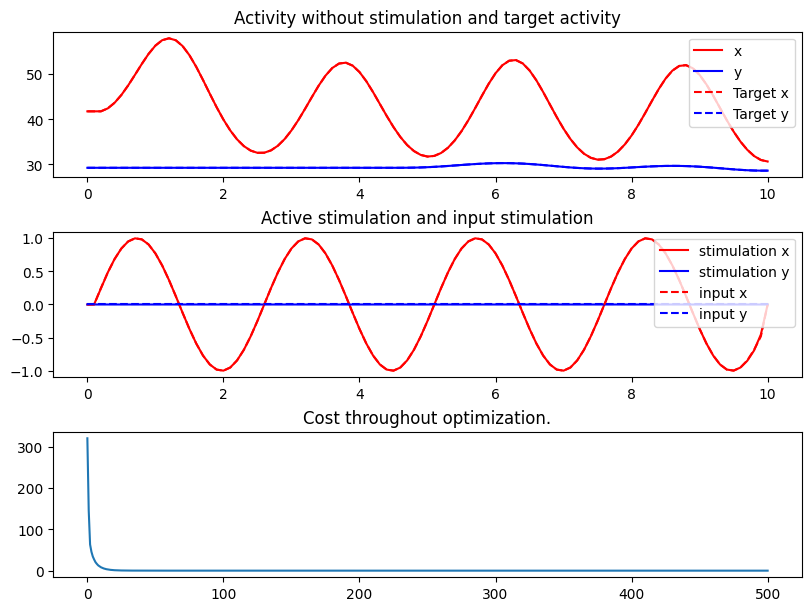

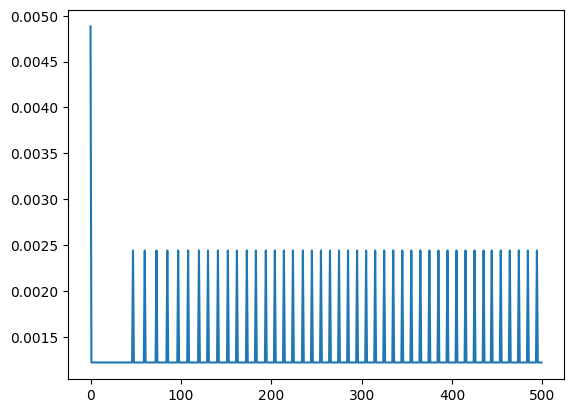

In [4]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25))
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 8.988196235839942e-05
Cost in iteration 25: 7.785551423666607e-05
Cost in iteration 50: 6.724519034319968e-05
Cost in iteration 75: 5.8633681519770616e-05
Cost in iteration 100: 5.106694905865047e-05
Final cost : 5.106694905865047e-05


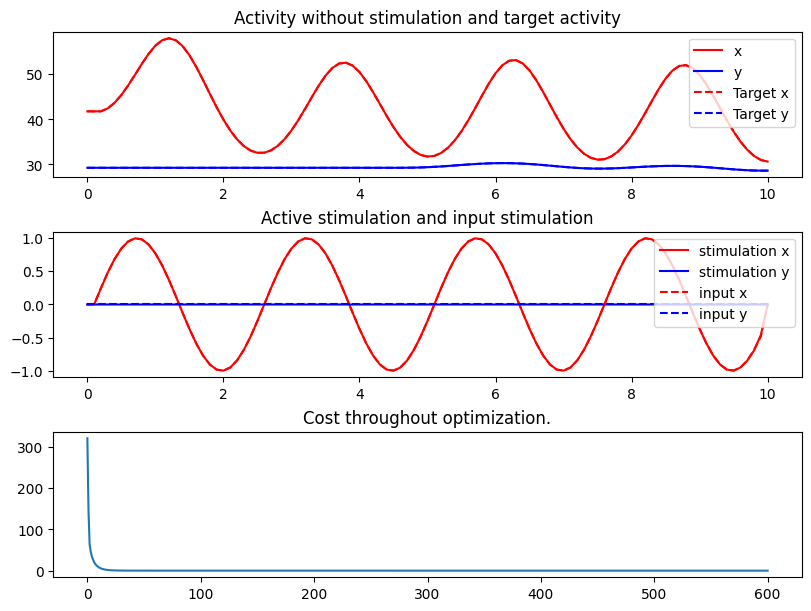

In [ ]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

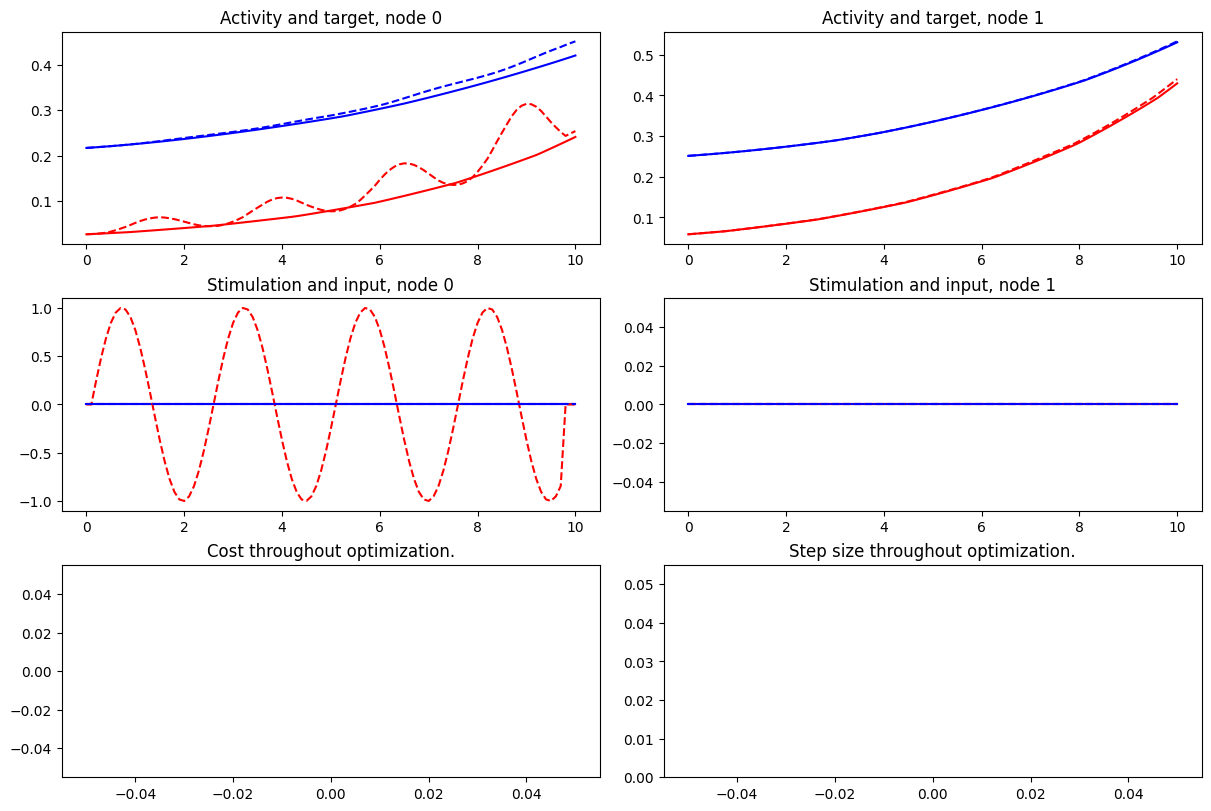

In [6]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = ALNModel(Cmat=cmat, Dmat=dmat)
model.params.de = 0.0
model.params.di = 0.0
model.run()
setinitstate(model, getfinalstate(model))

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.3, dt)/period) # other functions or random values can be used as well

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 6.12943703036621e-05
Cost in iteration 25: 5.581457006406001e-07
Cost in iteration 50: 4.561299136609919e-07
Cost in iteration 75: 4.137585618548614e-07
Cost in iteration 100: 3.8823963793540685e-07
Cost in iteration 125: 3.6829881588224445e-07
Cost in iteration 150: 3.4988443329032445e-07
Cost in iteration 175: 3.3554932486227604e-07
Cost in iteration 200: 3.2232419483934275e-07
Cost in iteration 225: 3.096452234468127e-07
Cost in iteration 250: 2.9829213487802373e-07
Cost in iteration 275: 2.880433499193965e-07
Cost in iteration 300: 2.790357722087519e-07
Cost in iteration 325: 2.705794195887848e-07
Cost in iteration 350: 2.633728261469501e-07
Cost in iteration 375: 2.5656614578736855e-07
Cost in iteration 400: 2.498930560731728e-07
Cost in iteration 425: 2.439233551954695e-07
Cost in iteration 450: 2.385336918916689e-07
Cost in iteration 475: 2.3392780556356618e-07
Cost in iteration 500: 2.3006065002839968e-07
Final cos

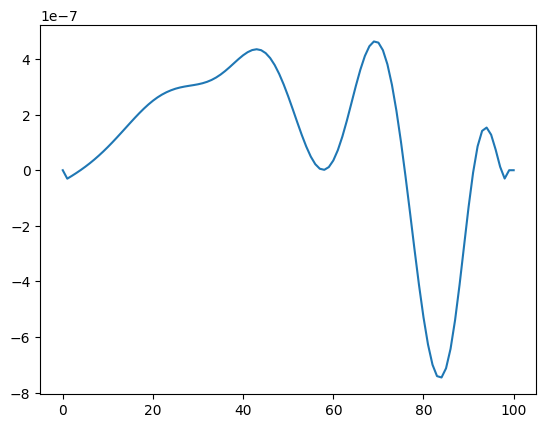

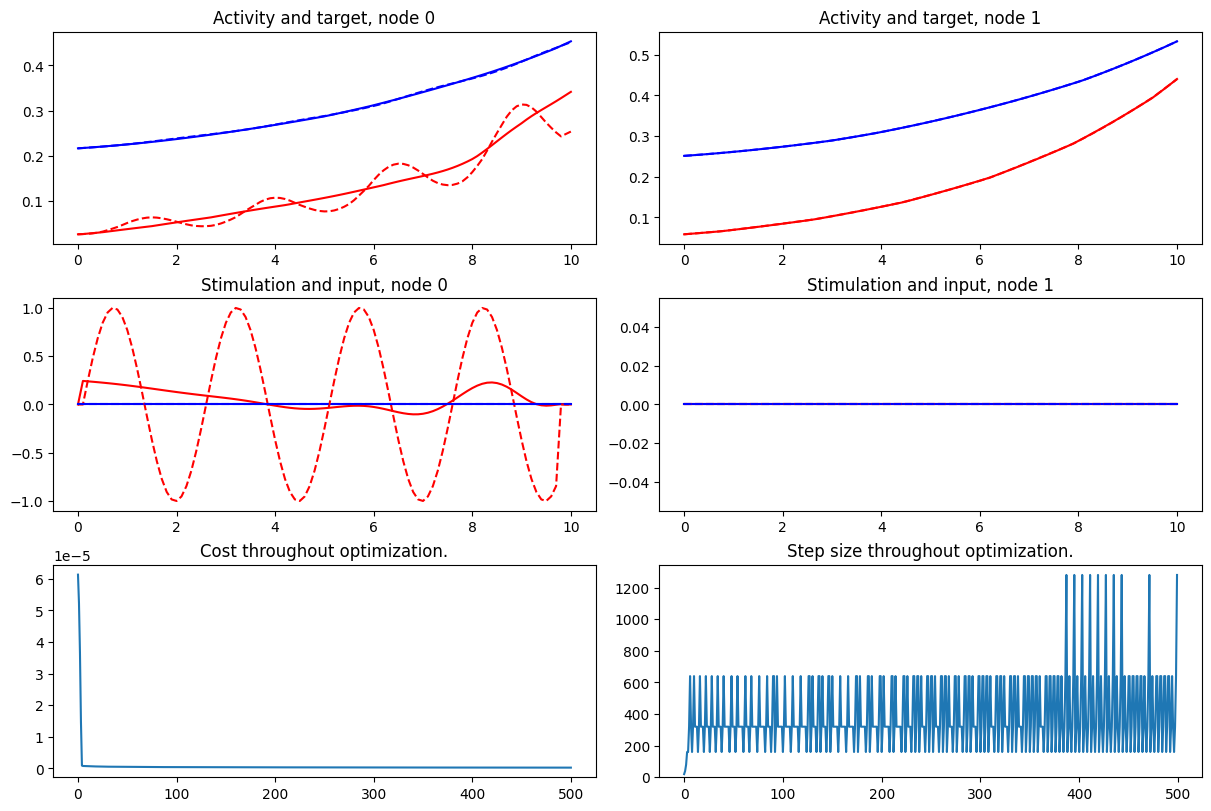

In [7]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

plt.plot(model_controlled.gradient[0,0,:])
plt.show()

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 2.3006065002839968e-07
Cost in iteration 100: 2.1631877079162776e-07
Cost in iteration 200: 2.0619353490544863e-07
Cost in iteration 300: 1.9766369284615456e-07
Cost in iteration 400: 1.9022823892913817e-07
Cost in iteration 500: 1.8317724637009937e-07
Cost in iteration 600: 1.7689434827395307e-07
Cost in iteration 700: 1.705561283021801e-07
Cost in iteration 800: 1.647325154194282e-07
Cost in iteration 900: 1.590941340107177e-07
Cost in iteration 1000: 1.5370791468594837e-07
Final cost : 1.5370791468594837e-07


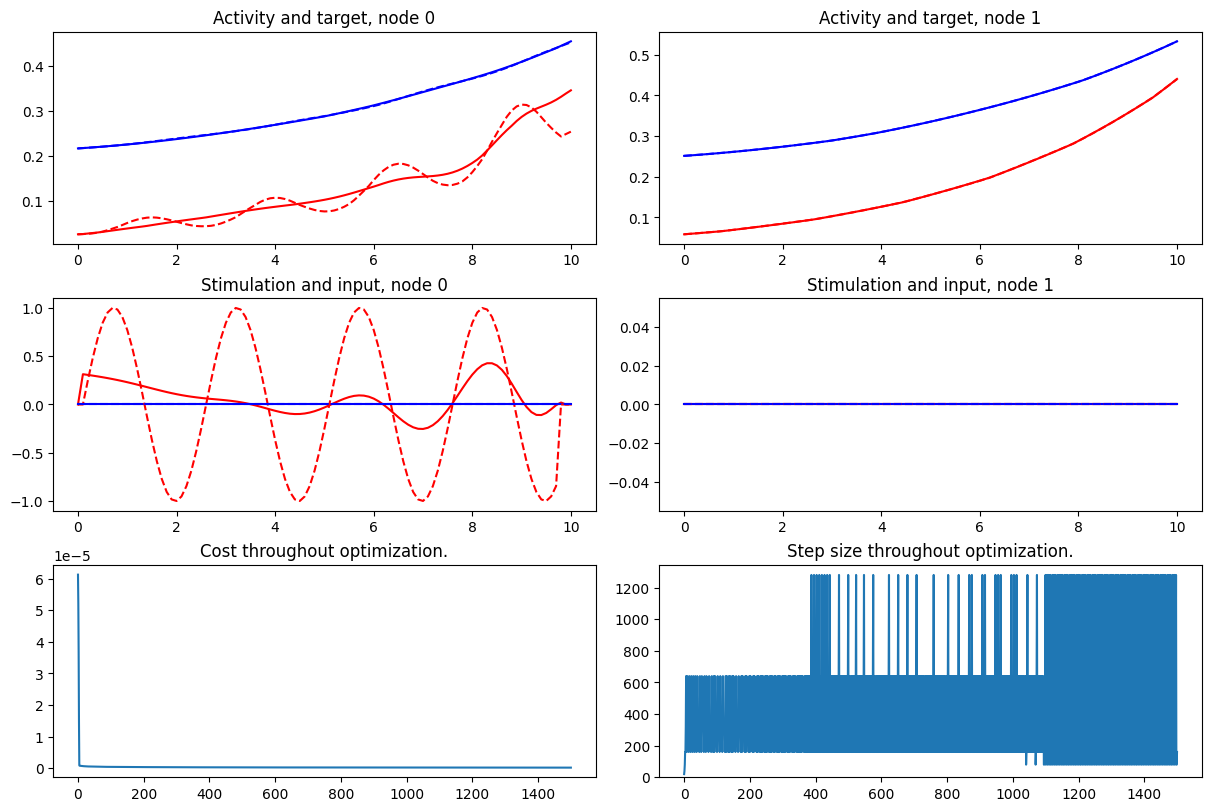

In [8]:
# Do another 1000 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.zero_step_encountered = False
model_controlled.print_array = np.arange(0,1001,100)
model_controlled.optimize(1000)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

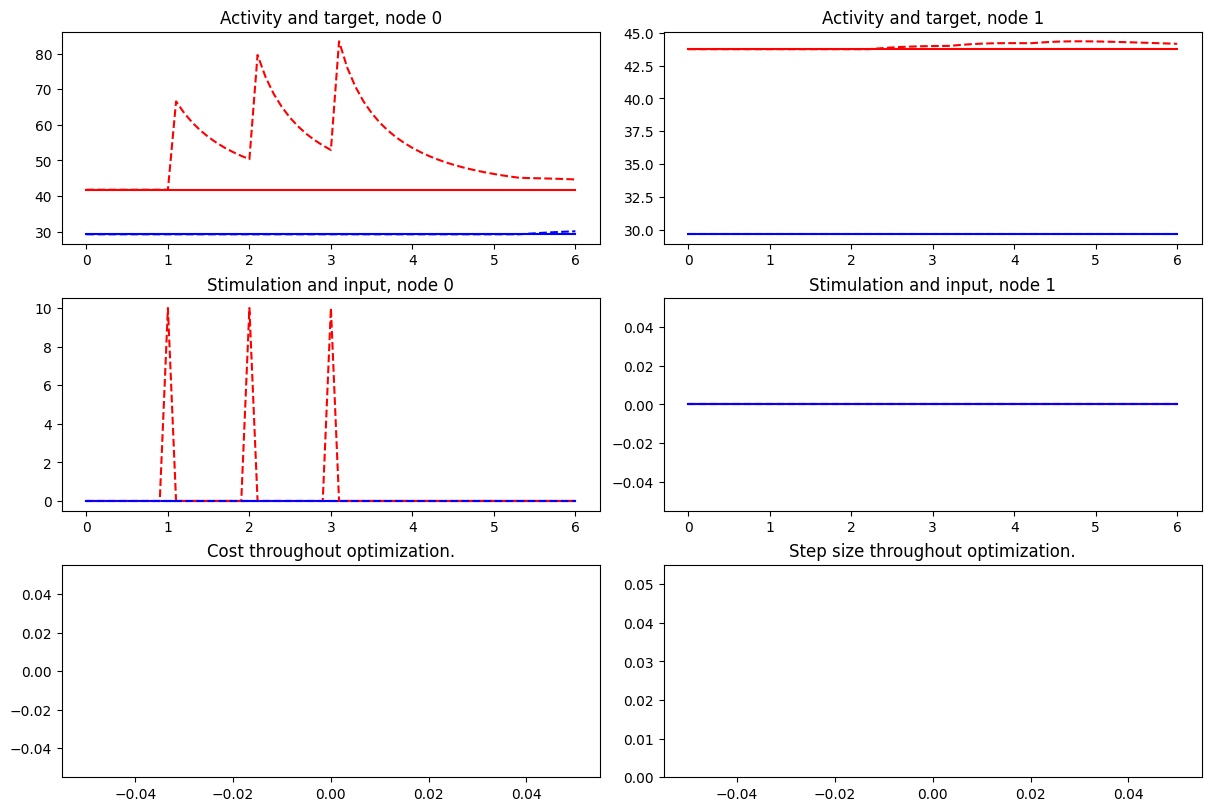

In [9]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = ALNModel(Cmat=cmat, Dmat=dmat)

model.params.mue_ext_mean = 2. # up state
model.run()
setinitstate(model, getfinalstate(model))

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 10. 
input[0,20] = 10.
input[0,30] = 10. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.3677113859658276
Cost in iteration 25: 0.0009647921994141611
Cost in iteration 50: 0.0007359744998249314
Cost in iteration 75: 0.0006239036840854146
Cost in iteration 100: 0.0005423618935823731
Cost in iteration 125: 0.00047904192989124125
Cost in iteration 150: 0.00042709966121482943
Cost in iteration 175: 0.0003833278036783011
Cost in iteration 200: 0.000345896788516975
Cost in iteration 225: 0.00031403147167032404
Cost in iteration 250: 0.00028677084017149194
Cost in iteration 275: 0.00026333323896998267
Cost in iteration 300: 0.0002422317031874977
Cost in iteration 325: 0.000223628029124899
Cost in iteration 350: 0.00020721217059824958
Cost in iteration 375: 0.0001926373568321884
Cost in iteration 400: 0.0001796616844732236
Cost in iteration 425: 0.00016840144819562372
Cost in iteration 450: 0.00015804376087725952
Cost in iteration 475: 0.00014929214710462515
Cost in iteration 500: 0.00014079199597476178
Final cost :

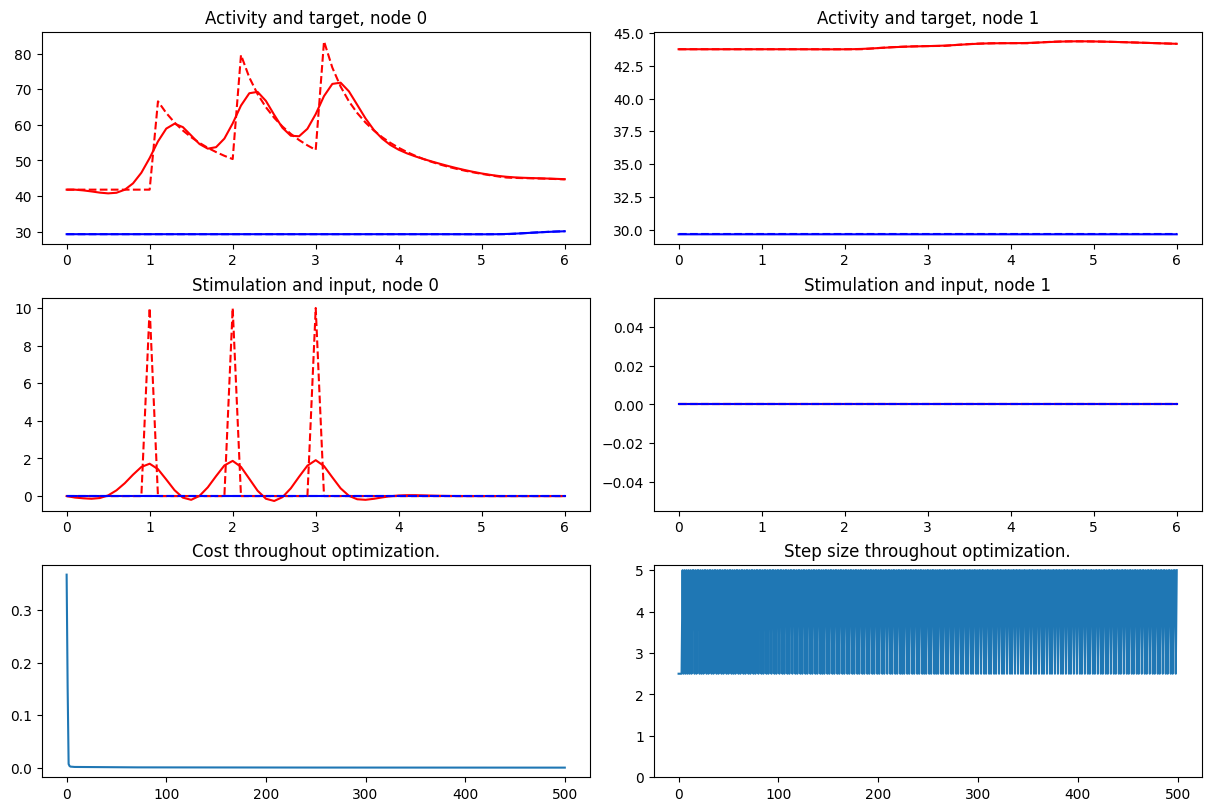

In [14]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 0.00014079199597476178
Cost in iteration 25: 0.00013346975744794596
Cost in iteration 50: 0.00012682854635705622
Cost in iteration 75: 0.00012077935370519
Cost in iteration 100: 0.00011533063531310664
Final cost : 0.00011533063531310664


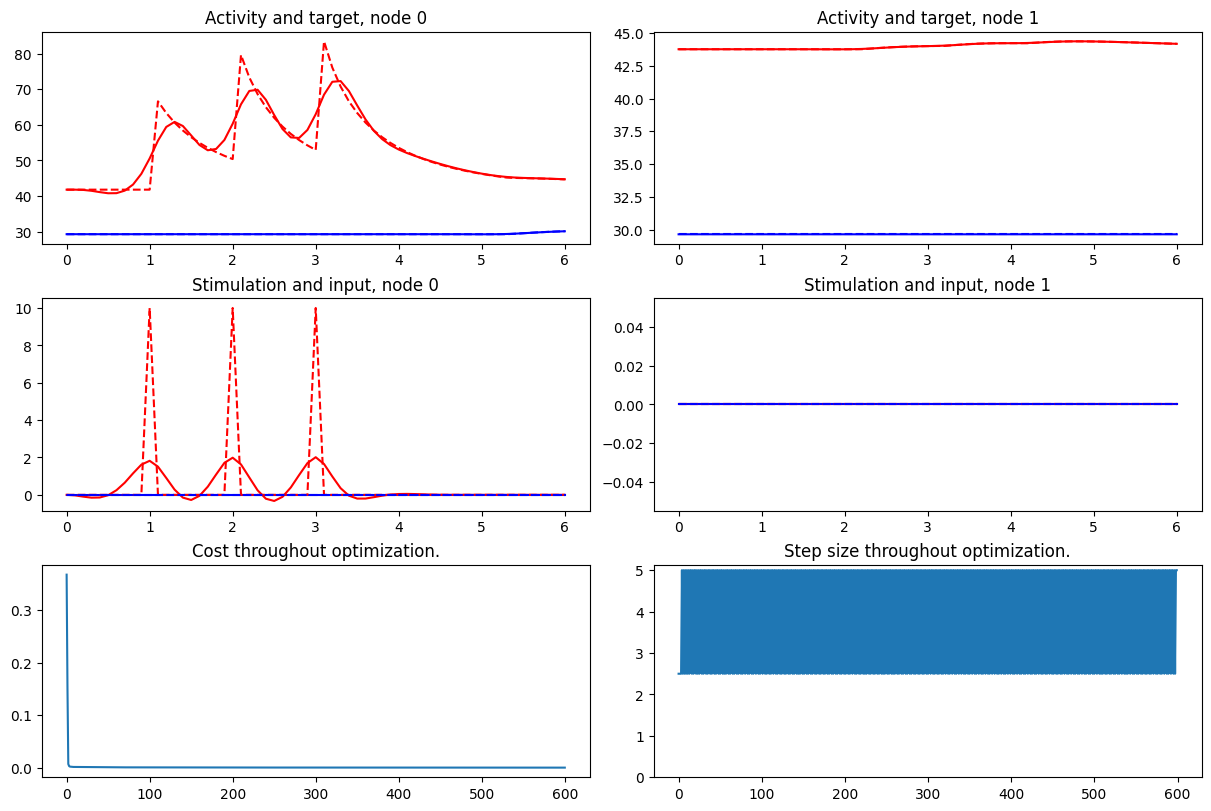

In [15]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 100 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)